In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Database connection
from sqlalchemy import create_engine


In [2]:
# Database credentials
# NOTE: Password will be moved to environment variables in Week-4
DB_USER = "root"
DB_PASSWORD = "1433"
DB_HOST = "localhost"
DB_NAME = "financial_analytics"

# Create SQLAlchemy engine for MySQL connection
engine = create_engine(
    f"mysql+mysqlconnector://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"
)


In [3]:
# Load certified market price data from MySQL
query = """
SELECT asset_id, trade_date, adj_close
FROM market_prices
ORDER BY asset_id, trade_date
"""

df = pd.read_sql(query, engine)

# Convert trade_date to datetime for time-series operations
df["trade_date"] = pd.to_datetime(df["trade_date"])

df.head()


,asset_id,trade_date,adj_close
0,1,2019-01-02,37.538822
1,1,2019-01-03,33.799679
2,1,2019-01-04,35.242561
3,1,2019-01-07,35.164124
4,1,2019-01-08,35.834446


In [4]:
# Check for missing values
df.isnull().sum()


asset_id      0
trade_date    0
adj_close     0
dtype: int64

In [5]:
# Ensure one row per asset per day
df.duplicated(subset=["asset_id", "trade_date"]).sum()


np.int64(0)

In [6]:
# Calculate daily log returns for each asset
# Using transform() ensures the result aligns with the original DataFrame index

df["log_return"] = (
    df
    .groupby("asset_id")["adj_close"]
    .transform(lambda x: np.log(x / x.shift(1)))
)

df.head()


,asset_id,trade_date,adj_close,log_return
0,1,2019-01-02,37.538822,NaN
1,1,2019-01-03,33.799679,-0.104924
2,1,2019-01-04,35.242561,0.041803
3,1,2019-01-07,35.164124,-0.002228
4,1,2019-01-08,35.834446,0.018883


In [7]:
df[["asset_id", "trade_date", "adj_close", "log_return"]].head(10)


,asset_id,trade_date,adj_close,log_return
0,1,2019-01-02,37.538822,NaN
1,1,2019-01-03,33.799679,-0.104924
2,1,2019-01-04,35.242561,0.041803
3,1,2019-01-07,35.164124,-0.002228
4,1,2019-01-08,35.834446,0.018883
5,1,2019-01-09,36.442982,0.016839
6,1,2019-01-10,36.559464,0.003191
7,1,2019-01-11,36.200520,-0.009867
8,1,2019-01-14,35.656178,-0.015151
9,1,2019-01-15,36.385941,0.020260


In [8]:
# Count NaNs in log_return
df["log_return"].isnull().sum()


np.int64(11)

In [9]:
# Verify no infinite or extreme values
df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [10]:
# Summary statistics of log returns
df["log_return"].describe()


count    19492.000000
mean         0.000695
std          0.019815
min         -0.236518
25%         -0.007187
50%          0.000818
75%          0.008877
max          0.204491
Name: log_return, dtype: float64

In [11]:
# Number of assets in the portfolio
num_assets = df["asset_id"].nunique()

# Equal weight assigned to each asset
equal_weight = 1 / num_assets


In [12]:
# Calculate portfolio daily return by aggregating
# weighted asset-level log returns

portfolio_returns = (
    df
    .dropna(subset=["log_return"])
    .groupby("trade_date")["log_return"]
    .mean()  # mean = equal-weighted portfolio
    .reset_index()
)

portfolio_returns.rename(
    columns={"log_return": "portfolio_log_return"},
    inplace=True
)

portfolio_returns.head()


,trade_date,portfolio_log_return
0,2019-01-03,-0.024549
1,2019-01-04,0.030525
2,2019-01-07,0.006518
3,2019-01-08,0.009343
4,2019-01-09,0.001594


In [13]:
# Summary statistics of portfolio returns
portfolio_returns["portfolio_log_return"].describe()


count    1772.000000
mean        0.000695
std         0.012059
min        -0.117414
25%        -0.004224
50%         0.001019
75%         0.006193
max         0.090411
Name: portfolio_log_return, dtype: float64

In [14]:
assert df["log_return"].isnull().sum() == num_assets


In [15]:
# Calculate 30-day rolling volatility for each asset
# Volatility = standard deviation of daily log returns

df["rolling_vol_30d"] = (
    df
    .groupby("asset_id")["log_return"]
    .transform(
        lambda x: x.rolling(window=30).std()
    )
)

df.head(35)


,asset_id,trade_date,adj_close,log_return,rolling_vol_30d
0,1,2019-01-02,37.538822,NaN,NaN
1,1,2019-01-03,33.799679,-0.104924,NaN
2,1,2019-01-04,35.242561,0.041803,NaN
3,1,2019-01-07,35.164124,-0.002228,NaN
4,1,2019-01-08,35.834446,0.018883,NaN
5,1,2019-01-09,36.442982,0.016839,NaN
6,1,2019-01-10,36.559464,0.003191,NaN
7,1,2019-01-11,36.200520,-0.009867,NaN
8,1,2019-01-14,35.656178,-0.015151,NaN
9,1,2019-01-15,36.385941,0.020260,NaN


In [16]:
# Count NaNs in rolling volatility
df["rolling_vol_30d"].isnull().sum()


np.int64(330)

In [17]:
# Summary statistics for rolling volatility
df["rolling_vol_30d"].describe()


count    19173.000000
mean         0.016528
std          0.011021
min          0.003503
25%          0.009881
50%          0.013167
75%          0.018532
max          0.088624
Name: rolling_vol_30d, dtype: float64

In [18]:
# Calculate 30-day rolling volatility for the portfolio

portfolio_returns["rolling_vol_30d"] = (
    portfolio_returns["portfolio_log_return"]
    .rolling(window=30)
    .std()
)

portfolio_returns.head(35)


,trade_date,portfolio_log_return,rolling_vol_30d
0,2019-01-03,-0.024549,NaN
1,2019-01-04,0.030525,NaN
2,2019-01-07,0.006518,NaN
3,2019-01-08,0.009343,NaN
4,2019-01-09,0.001594,NaN
5,2019-01-10,0.002954,NaN
6,2019-01-11,0.000357,NaN
7,2019-01-14,-0.005486,NaN
8,2019-01-15,0.012392,NaN
9,2019-01-16,0.005945,NaN


In [19]:
# Summary statistics of portfolio rolling volatility
portfolio_returns["rolling_vol_30d"].describe()


count    1743.000000
mean        0.010179
std         0.006622
min         0.003990
25%         0.006530
50%         0.008265
75%         0.011378
max         0.052497
Name: rolling_vol_30d, dtype: float64

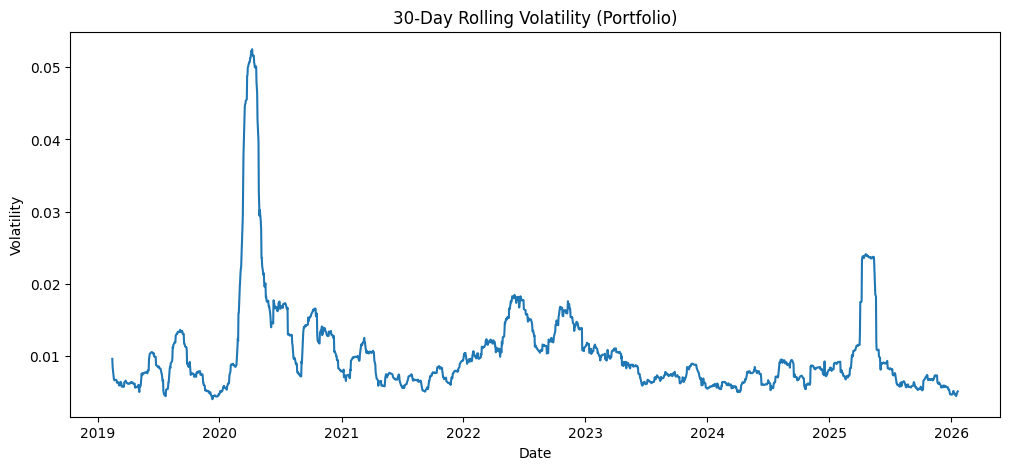

In [20]:
import matplotlib.pyplot as plt

# Plot portfolio rolling volatility
plt.figure(figsize=(12, 5))
plt.plot(
    portfolio_returns["trade_date"],
    portfolio_returns["rolling_vol_30d"]
)
plt.title("30-Day Rolling Volatility (Portfolio)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [21]:
# Pivot log returns into wide format for correlation analysis
# Rows = trade_date
# Columns = asset_id
# Values = log_return

returns_matrix = (
    df
    .pivot(index="trade_date", columns="asset_id", values="log_return")
)

returns_matrix.head()


asset_id,1,2,3,4,5,6,7,8,9,10,11
trade_date,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.104924,-0.037482,-0.014314,-0.016156,-0.015473,-0.007036,-0.016018,-0.031978,-0.005156,0.003564,-0.025068
2019-01-04,0.041803,0.045460,0.036203,0.040692,0.036206,0.020205,0.016644,0.056094,0.006227,0.002487,0.033759
2019-01-07,-0.002228,0.001274,0.000695,-0.000782,0.005186,-0.004008,-0.006435,0.052935,0.011703,0.006367,0.006986
2019-01-08,0.018883,0.007225,-0.001887,-0.001958,0.007245,0.003684,0.022961,0.001164,0.006957,0.028846,0.009649


In [22]:
# Check shape of the matrix
returns_matrix.shape


(1773, 11)

In [23]:
# Check missing values
returns_matrix.isnull().sum()


asset_id
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
dtype: int64

In [24]:
# Calculate Pearson correlation matrix of asset returns
correlation_matrix = returns_matrix.corr()

correlation_matrix


asset_id,1,2,3,4,5,6,7,8,9,10,11
asset_id,,,,,,,,,,,
1,1.000000,0.700158,0.425093,0.433019,0.302457,0.374193,0.318221,0.481200,0.351963,0.238777,0.777180
2,0.700158,1.000000,0.430032,0.422099,0.245128,0.378798,0.298008,0.440963,0.359511,0.206825,0.805289
3,0.425093,0.430032,1.000000,0.879435,0.547356,0.317599,0.346492,0.302042,0.261693,0.315679,0.714702
4,0.433019,0.422099,0.879435,1.000000,0.571802,0.323415,0.334238,0.302621,0.272060,0.336042,0.709748
5,0.302457,0.245128,0.547356,0.571802,1.000000,0.220608,0.277791,0.161088,0.172751,0.289219,0.513540
6,0.374193,0.378798,0.317599,0.323415,0.220608,1.000000,0.549311,0.090402,0.467847,0.458961,0.486913
7,0.318221,0.298008,0.346492,0.334238,0.277791,0.549311,1.000000,0.061745,0.335829,0.401749,0.443297
8,0.481200,0.440963,0.302042,0.302621,0.161088,0.090402,0.061745,1.000000,0.169011,0.023455,0.519764
9,0.351963,0.359511,0.261693,0.272060,0.172751,0.467847,0.335829,0.169011,1.000000,0.276622,0.435134


In [25]:
# Correlation matrix should be symmetric
(correlation_matrix.values.T == correlation_matrix.values).all()


np.True_

In [26]:
# Diagonal values should be 1 (asset correlated with itself)
np.diag(correlation_matrix)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
# Rename index and column names to avoid duplication during reset_index
correlation_matrix.index.name = "asset_id_1"
correlation_matrix.columns.name = "asset_id_2"


In [31]:
# Extract upper triangle correlations to avoid duplicate pairs
high_corr_pairs = (
    correlation_matrix
    .where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index(name="correlation")
)

# Filter high-correlation pairs
high_corr_pairs[
    high_corr_pairs["correlation"].abs() > 0.8
].sort_values(by="correlation", ascending=False)


,asset_id_1,asset_id_2,correlation
19,3,4,0.879435
18,2,11,0.805289


In [32]:
high_corr_pairs.head()


,asset_id_1,asset_id_2,correlation
0,1,2,0.700158
1,1,3,0.425093
2,1,4,0.433019
3,1,5,0.302457
4,1,6,0.374193


In [33]:
high_corr_pairs.columns


Index(['asset_id_1', 'asset_id_2', 'correlation'], dtype='object')